In [105]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

In [106]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style
style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [107]:
from local_settings import GOOGLE_API_KEY
gmaps.configure(GOOGLE_API_KEY)

# ER Visits to NYC Hospitals with COVID-19 Like Symptoms

## Processing

In [108]:
ili_df = pd.read_excel('data/epiquery_nyc_ili_diseases.xlsx')
resp_df = pd.read_excel('data/epiquery_nyc_respiratory_diseases.xlsx')

In [109]:
ili_df['Symptoms'] = 'Flu-like'
resp_df['Symptoms'] = 'Respiratory'

In [110]:
df = pd.concat([ili_df, resp_df])

In [111]:
df['Date'] = pd.to_datetime(df['Date '])
df['Value'] = df['Unnamed: 8'].astype(int)

In [112]:
df['Date'].max()

Timestamp('2020-04-04 00:00:00')

In [113]:
df

,Data note 1,Ind1Name,Dim1Name,Dim1Value,Dim2Name,Dim2Value,Date,Select Metric,Unnamed: 8,Symptoms,Date,Value
0,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Borough,Bronx,Age Group,All age groups,1/1/16,Count,73,Flu-like,2016-01-01,73
1,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Borough,Bronx,Age Group,All age groups,1/2/16,Count,92,Flu-like,2016-01-02,92
2,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Borough,Bronx,Age Group,All age groups,1/3/16,Count,72,Flu-like,2016-01-03,72
3,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Borough,Bronx,Age Group,All age groups,1/4/16,Count,93,Flu-like,2016-01-04,93
4,-Syndrome data are inherently non-specific and...,Influenza-like illness (ILI),Borough,Bronx,Age Group,All age groups,1/5/16,Count,60,Flu-like,2016-01-05,60
...,...,...,...,...,...,...,...,...,...,...,...,...
54210,-Syndrome data are inherently non-specific and...,Respiratory,Citywide,Citywide,Age Group,Ages 65+ years,3/31/20,Count,1015,Respiratory,2020-03-31,1015
54211,-Syndrome data are inherently non-specific and...,Respiratory,Citywide,Citywide,Age Group,Ages 65+ years,4/1/20,Count,1033,Respiratory,2020-04-01,1033
54212,-Syndrome data are inherently non-specific and...,Respiratory,Citywide,Citywide,Age Group,Ages 65+ years,4/2/20,Count,863,Respiratory,2020-04-02,863
54213,-Syndrome data are inherently non-specific and...,Respiratory,Citywide,Citywide,Age Group,Ages 65+ years,4/3/20,Count,914,Respiratory,2020-04-03,914


In [114]:
citywide_all = df[(df['Dim1Name'] == 'Citywide') & (df['Dim2Value'] == 'All age groups')]
%store citywide_all

Stored 'citywide_all' (DataFrame)


## Analysis

In [115]:
citywide_all[(citywide_all['Date'] >= '2019-03-01') & (citywide_all['Date'] < '2020-03-01')].groupby('Date')['Value'].sum().resample('D').sum().max()

3520

In [116]:
citywide_all[citywide_all['Date'] >= '2018-03-01'].groupby('Date')['Value'].sum().resample('D').sum()

Date
2018-03-01    1785
2018-03-02    1281
2018-03-03    1505
2018-03-04    1514
2018-03-05    1817
              ... 
2020-03-31    4483
2020-04-01    4089
2020-04-02    3660
2020-04-03    3564
2020-04-04    2825
Freq: D, Name: Value, Length: 766, dtype: int64

/home/rspectre/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  if __name__ == '__main__':


Text(2019-05-30 00:00:00, 5946, '25 Mar 2020: 5856')

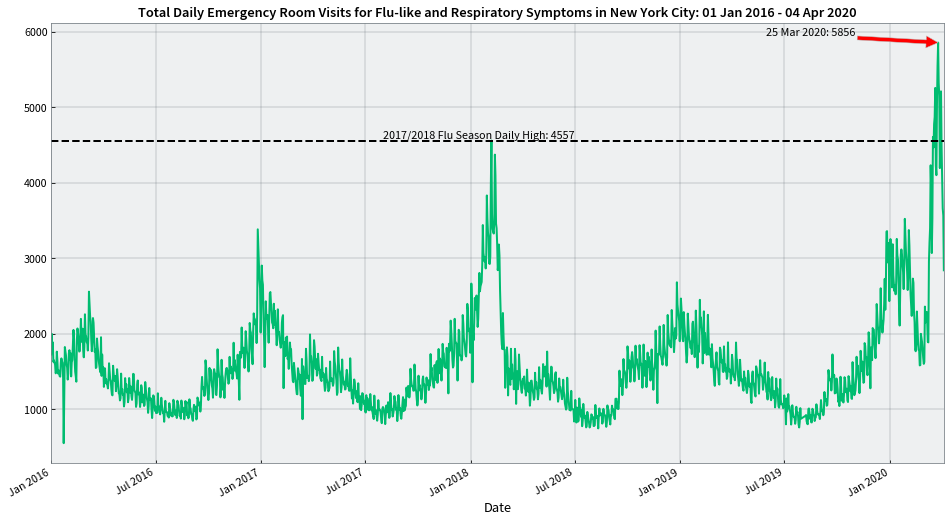

In [117]:
ax = citywide_all.groupby('Date')['Value'].sum().plot(kind='line',
                                                      title="Total Daily Emergency Room Visits for Flu-like and Respiratory Symptoms in New York City: {0} - {1}".format(df['Date'].min().strftime("%d %b %Y"), df['Date'].max().strftime("%d %b %Y")))

ax.axhline(citywide_all[citywide_all['Date'] <= '2020-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max(),
           linestyle='--', color='k')
ax.text("2017-08-01", 4590, "2017/2018 Flu Season Daily High: {0}".format(citywide_all[citywide_all['Date'] <= '2020-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max()))
ax.annotate("{0}: {1}".format(citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().idxmax().date().strftime("%d %b %Y"), citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max()),
            xy=(citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().idxmax(), citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max()),
            xytext=(citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().idxmax() - 300,
                    citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max() + 90),
            arrowprops={'facecolor': 'red'})

/home/rspectre/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  


Text(2020-01-05 00:00:00, 5881, '25 Mar 2020: 5856')

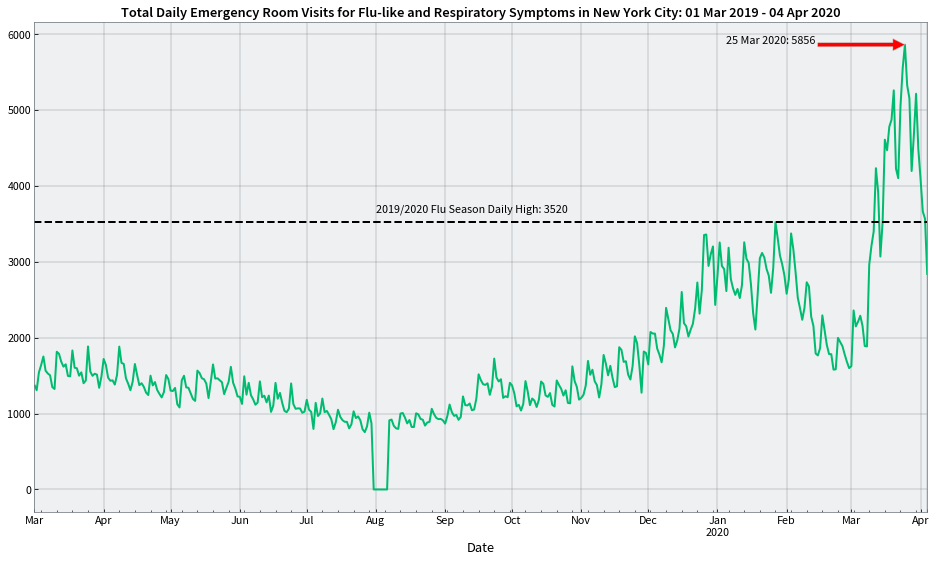

In [118]:
ax = citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().plot(kind='line',
                                                                                                                title="Total Daily Emergency Room Visits for Flu-like and Respiratory Symptoms in New York City: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2019-03-01']['Date'].min().date().strftime("%d %b %Y"), citywide_all['Date'].max().date().strftime("%d %b %Y")))
ax.axhline(citywide_all[(citywide_all['Date'] >= '2019-12-01') & (citywide_all['Date'] <= '2020-03-01')].groupby('Date')['Value'].sum().resample('D').sum().max(),
           linestyle='--', color='k')
ax.text("2019-08-01", 3650, "2019/2020 Flu Season Daily High: {0}".format(citywide_all[(citywide_all['Date'] >= '2019-12-01') & (citywide_all['Date'] <= '2020-03-01')].groupby('Date')['Value'].sum().resample('D').sum().max()))
ax.annotate("{0}: {1}".format(citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().idxmax().date().strftime("%d %b %Y"), citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max()),
            xy=(citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().idxmax(), citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max()),
            xytext=(citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().idxmax() - 80, citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max() + 25),
            arrowprops={'facecolor': 'red'})

In [119]:
citywide_all[citywide_all['Date'] >= '2020-03-01'].groupby('Date')['Value'].sum().resample('D').sum().sum()

132741

/home/rspectre/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  


Text(2020-03-05 00:00:00, 5881, '25 Mar 2020: 5856')

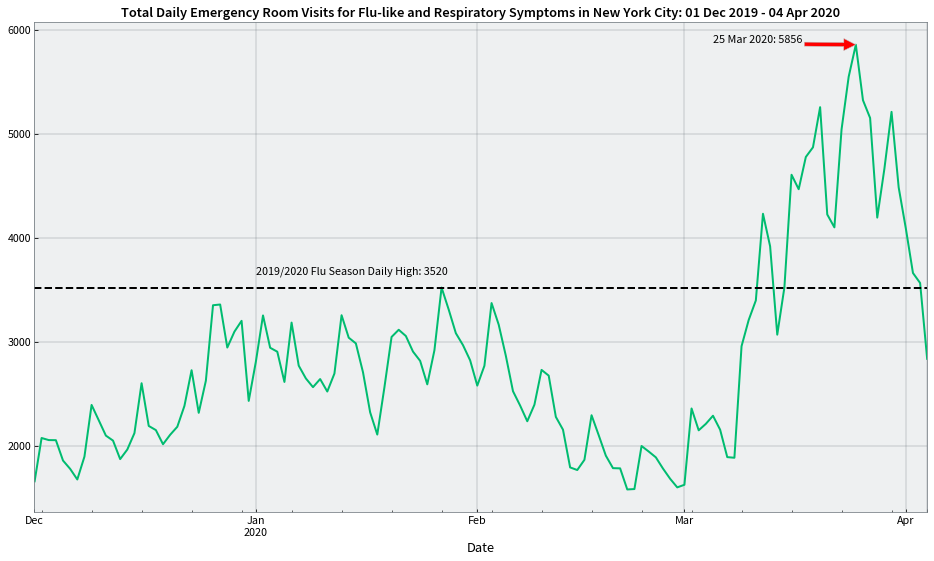

In [120]:
ax = citywide_all[citywide_all['Date'] >= '2019-12-01'].groupby('Date')['Value'].sum().resample('D').sum().plot(kind='line',
                                                                                                                title="Total Daily Emergency Room Visits for Flu-like and Respiratory Symptoms in New York City: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2019-12-01']['Date'].min().date().strftime("%d %b %Y"), citywide_all['Date'].max().date().strftime("%d %b %Y")))
ax.axhline(citywide_all[(citywide_all['Date'] >= '2019-12-01') & (citywide_all['Date'] <= '2020-03-01')].groupby('Date')['Value'].sum().resample('D').sum().max(),
           linestyle='--', color='k')
ax.text("2020-01-01", 3650, "2019/2020 Flu Season Daily High: {0}".format(citywide_all[(citywide_all['Date'] >= '2019-12-01') & (citywide_all['Date'] <= '2020-03-01')].groupby('Date')['Value'].sum().resample('D').sum().max()))
ax.annotate("{0}: {1}".format(citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().idxmax().date().strftime("%d %b %Y"), citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max()),
            xy=(citywide_all[citywide_all['Date'] >= '2019-12-01'].groupby('Date')['Value'].sum().resample('D').sum().idxmax(), citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max()),
            xytext=(citywide_all[citywide_all['Date'] >= '2020-02-01'].groupby('Date')['Value'].sum().resample('D').sum().idxmax() - 20, citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().max() + 25),
            arrowprops={'facecolor': 'red'})

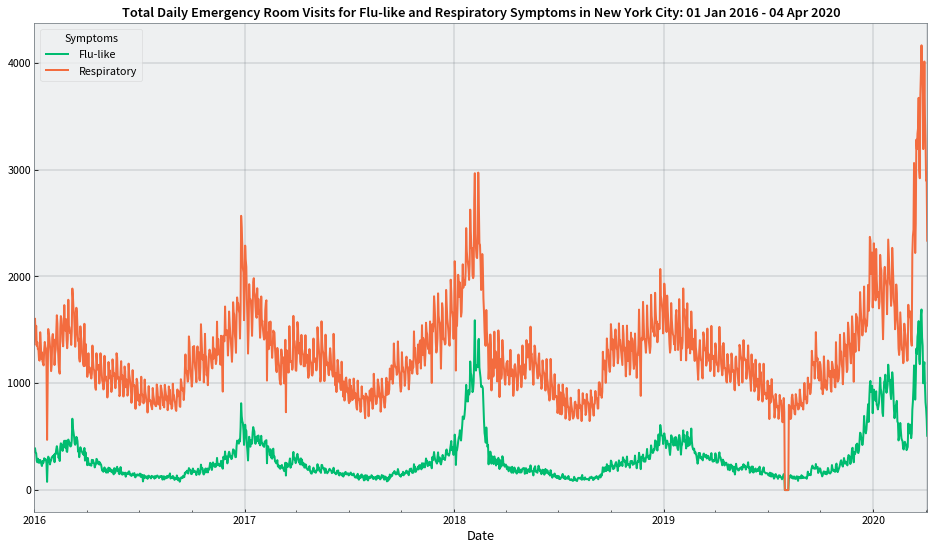

In [121]:
ax = citywide_all.groupby(['Date', 'Symptoms'])['Value'].sum().unstack('Symptoms').resample('D').sum().plot(kind='line',
                                                                                                                title="Total Daily Emergency Room Visits for Flu-like and Respiratory Symptoms in New York City: {0} - {1}".format(citywide_all['Date'].min().date().strftime("%d %b %Y"), citywide_all['Date'].max().date().strftime("%d %b %Y")))

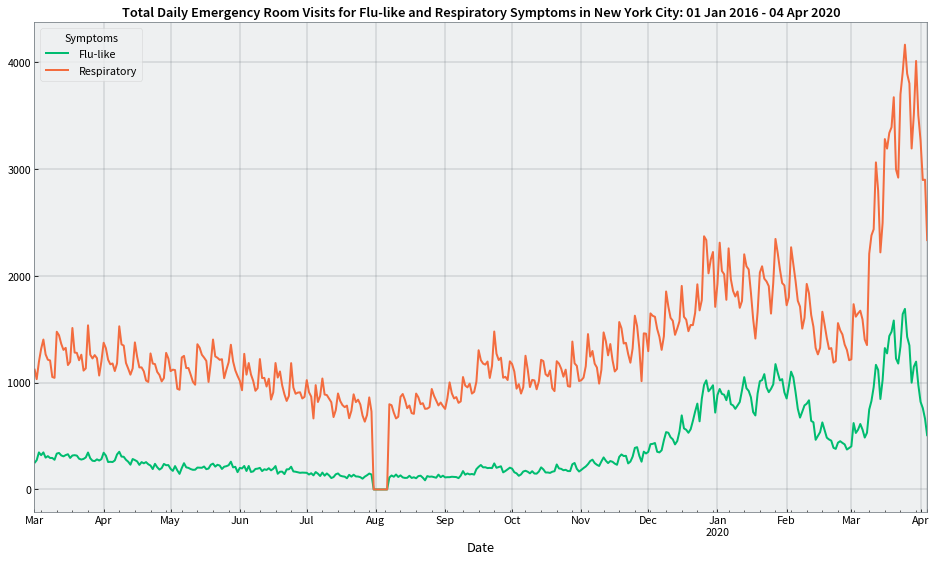

In [122]:
ax = citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby(['Date', 'Symptoms'])['Value'].sum().unstack('Symptoms').resample('D').sum().plot(kind='line',
                                                                                                                title="Total Daily Emergency Room Visits for Flu-like and Respiratory Symptoms in New York City: {0} - {1}".format(citywide_all['Date'].min().date().strftime("%d %b %Y"), citywide_all['Date'].max().date().strftime("%d %b %Y")))

In [123]:
y = citywide_all.groupby('Date')['Value'].sum().resample('D').sum()
w_y = citywide_all.groupby('Date')['Value'].sum().resample('W').sum()

In [124]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [125]:
from tqdm import tqdm

In [126]:
'''
# Grid search for optimal SARIMAX parameters

previous_best = 100000000

for param in pdq:
    for param_seasonal in tqdm(seasonal_pdq):
        try:
            mod = sm.tsa.statespace.SARIMAX(w_y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            if results.aic < previous_best:
                previous_best = results.aic
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
'''

"\n# Grid search for optimal SARIMAX parameters\n\nprevious_best = 100000000\n\nfor param in pdq:\n    for param_seasonal in tqdm(seasonal_pdq):\n        try:\n            mod = sm.tsa.statespace.SARIMAX(w_y,\n                                            order=param,\n                                            seasonal_order=param_seasonal,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n            results = mod.fit()\n            \n            if results.aic < previous_best:\n                previous_best = results.aic\n                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))\n        except:\n            continue\n"

In [127]:
# ARIMA(1, 1, 1)x(1, 1, 1, 52)12 - AIC:19455.336204840307 against daily data
# ARIMA(1, 1, 1)x(1, 1, 0, 52)12 - AIC:2010.5736042684719 against weekly data

In [128]:
model = sm.tsa.statespace.SARIMAX(y,
                                  order=(1, 1, 1),
                                  seasonal_order=(1, 1, 1, 52),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()

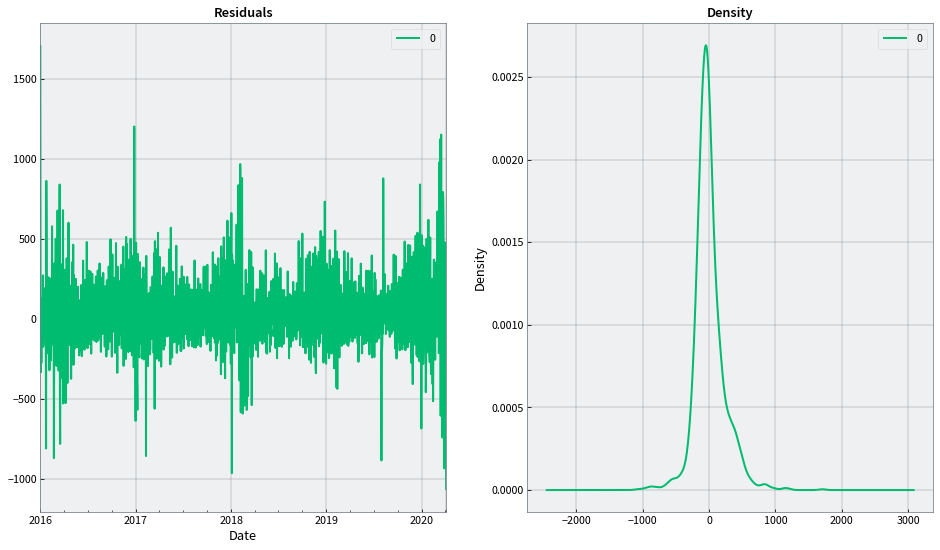

In [129]:
figsize(16,9)
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

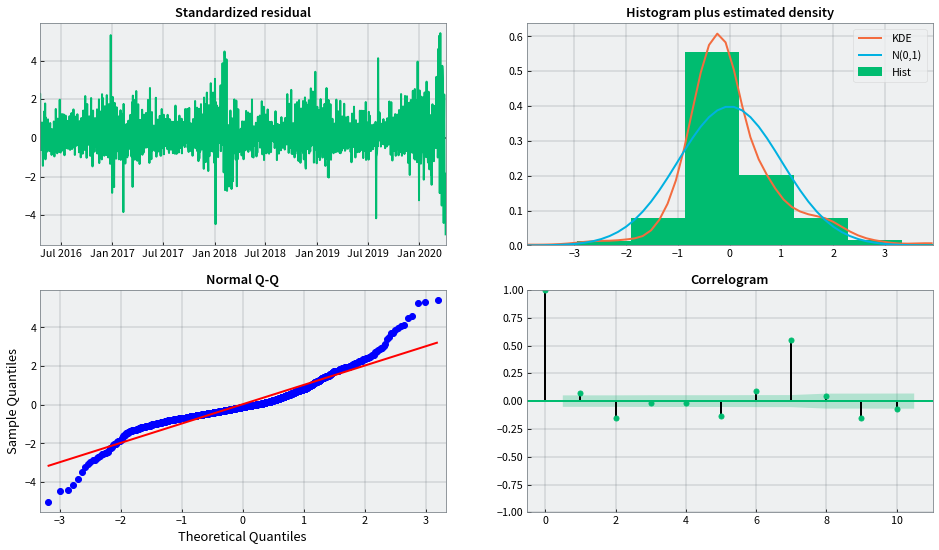

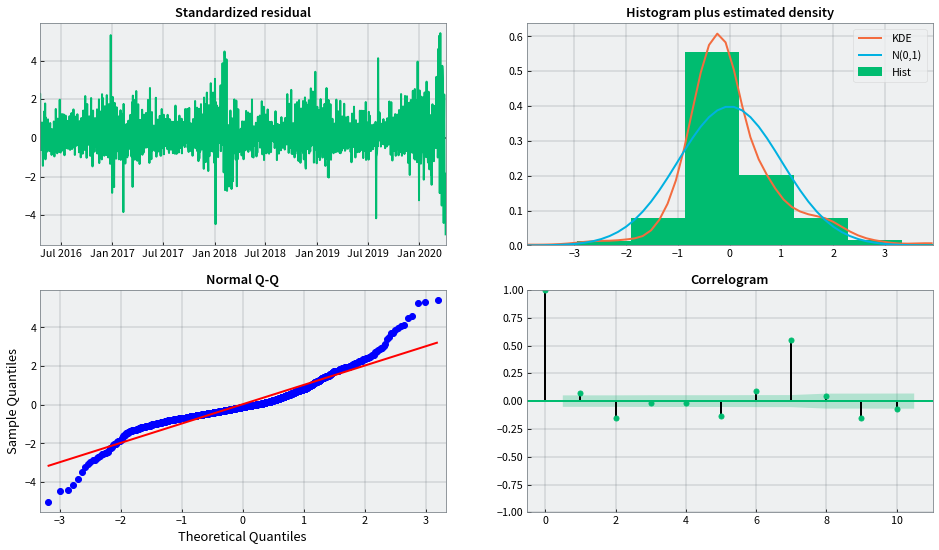

In [130]:
results.plot_diagnostics()

In [131]:
fc = results.get_prediction(start='2020-04-04', end='2020-05-30', anchor="2020-04-03", alpha=0.05, full_results=True)

conf = fc.conf_int(alpha=0.05)

pd.plotting.register_matplotlib_converters()

lower_series = pd.Series(conf.iloc[:, 0], fc.predicted_mean.index)
upper_series = pd.Series(conf.iloc[:, 1], fc.predicted_mean.index)

%store fc
%store conf

Stored 'fc' (PredictionResultsWrapper)
Stored 'conf' (DataFrame)


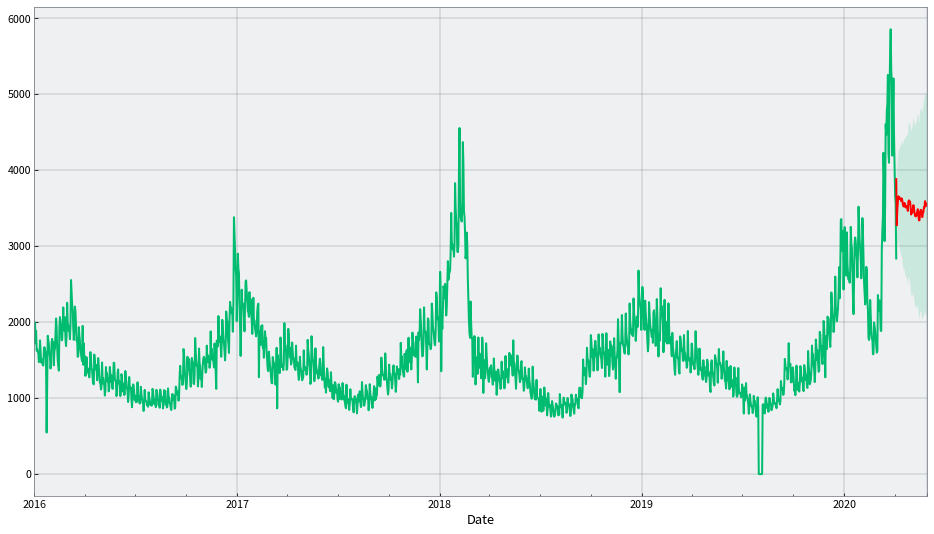

In [132]:
figsize(16, 9)
ax = citywide_all.groupby('Date')['Value'].sum().resample('D').sum().plot(kind='line')

fc.predicted_mean.plot(kind='line', color='red', ax=ax)
ax.fill_between(fc.predicted_mean.index, lower_series, upper_series, alpha=0.15)

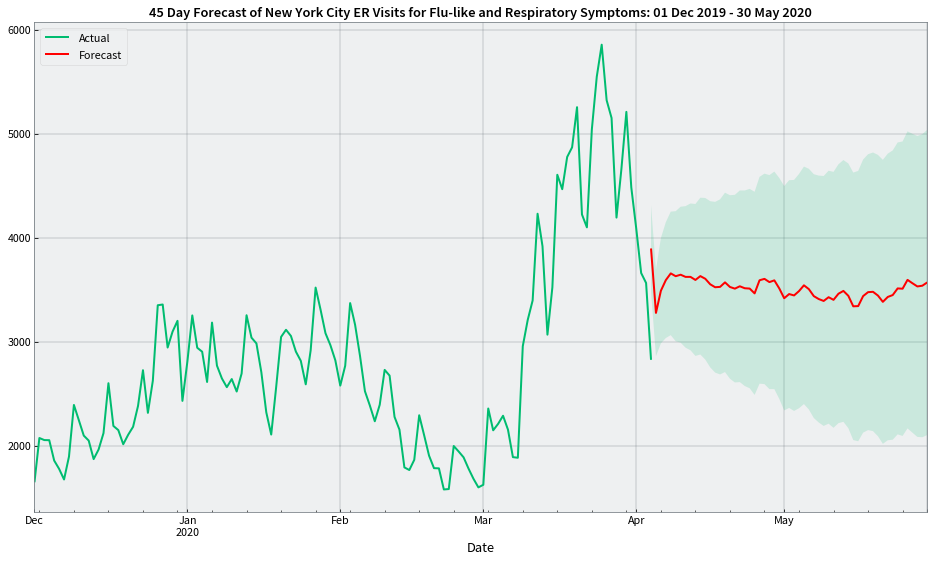

In [133]:
figsize(16, 9)
ax = citywide_all[citywide_all['Date'] >= '2019-12-01'].groupby('Date')['Value'].sum().resample('D').sum().plot(kind='line',
                                                                                                                label="Actual",
                                                                                                                legend=True,
                                                                                                                title="45 Day Forecast of New York City ER Visits for Flu-like and Respiratory Symptoms: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2019-12-01']['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                                           fc.predicted_mean.index.max().date().strftime("%d %b %Y")))

fc.predicted_mean.plot(kind='line', color='red', label="Forecast", ax=ax, legend=True)
ax.fill_between(fc.predicted_mean.index, lower_series, upper_series, alpha=0.15)
ax.legend(loc='upper left')

In [134]:
old_fc = results.get_prediction(start='2020-03-25', end='2020-05-14', anchor="2020-03-25", alpha=0.05, full_results=True)

old_conf = old_fc.conf_int(alpha=0.05)

pd.plotting.register_matplotlib_converters()

old_lower_series = pd.Series(old_conf.iloc[:, 0], old_fc.predicted_mean.index)
old_upper_series = pd.Series(old_conf.iloc[:, 1], old_fc.predicted_mean.index)

In [135]:
longterm = results.get_prediction(start='2020-03-31', end='2020-09-24', anchor="2020-03-31", alpha=0.05, full_results=True)

conf = longterm.conf_int(alpha=0.05)

longterm_lower_series = pd.Series(conf.iloc[:, 0], longterm.predicted_mean.index)
longterm_upper_series = pd.Series(conf.iloc[:, 1], longterm.predicted_mean.index)

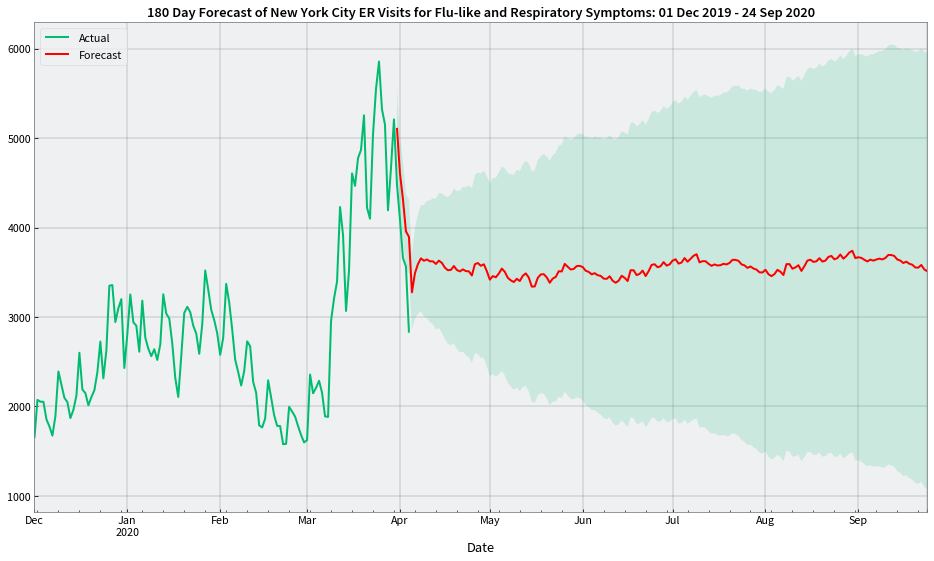

In [136]:
figsize(16, 9)
ax = citywide_all[citywide_all['Date'] >= '2019-12-01'].groupby('Date')['Value'].sum().resample('D').sum().plot(kind='line',
                                                                                                                label="Actual",
                                                                                                                legend=True,
                                                                                                                title="180 Day Forecast of New York City ER Visits for Flu-like and Respiratory Symptoms: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2019-12-01']['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                                           longterm.predicted_mean.index.max().date().strftime("%d %b %Y")))

longterm.predicted_mean.plot(kind='line', color='red', label="Forecast", ax=ax, legend=True)
ax.fill_between(longterm.predicted_mean.index, longterm_lower_series, longterm_upper_series, alpha=0.15)
ax.legend(loc='upper left')

In [137]:
from fbprophet import Prophet

p = Prophet()
fitted_p = p.fit(citywide_all.groupby('Date')['Value'].sum().resample('D').sum().to_frame().reset_index().rename(columns={'Date': 'ds', 'Value': 'y'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [138]:
future = fitted_p.make_future_dataframe(periods=45)

In [139]:
forecast = fitted_p.predict(future)

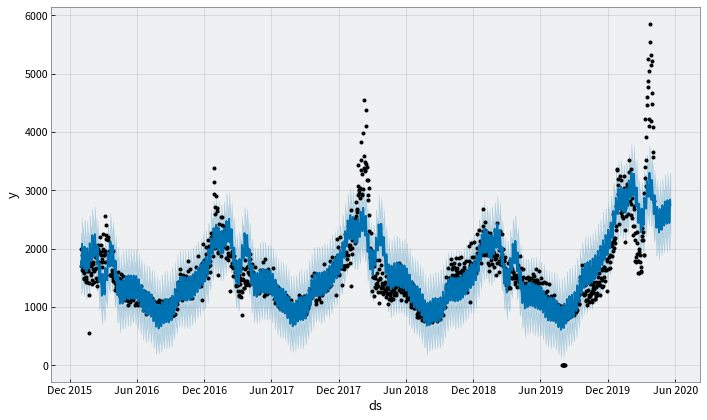

In [140]:
fig1 = fitted_p.plot(forecast)

In [141]:
boroughs = df[-(df['Dim1Value'] == 'Citywide') & (df['Dim2Value'] == 'All age groups')]

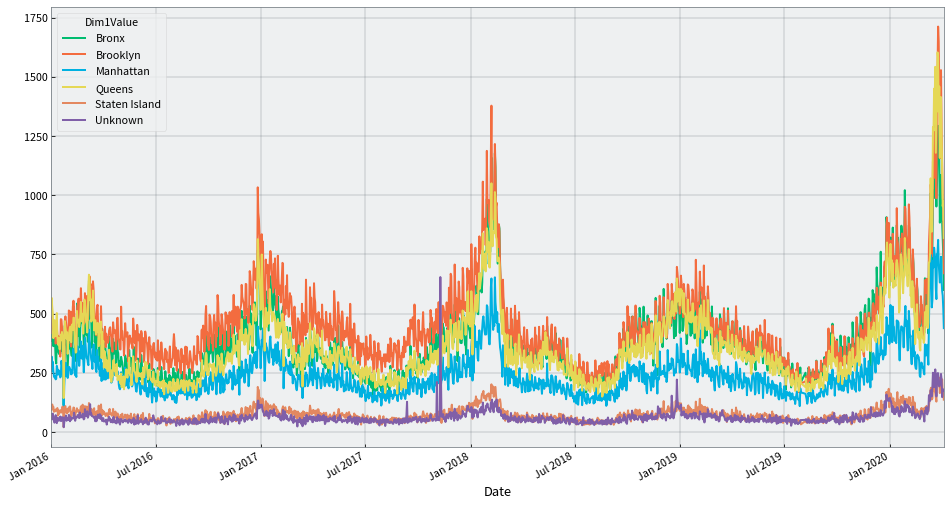

In [142]:
boroughs.groupby(['Date', 'Dim1Value'])['Value'].sum().unstack('Dim1Value').plot(kind='line')

In [143]:
boroughs['Borough'] = boroughs['Dim1Value']

/home/rspectre/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


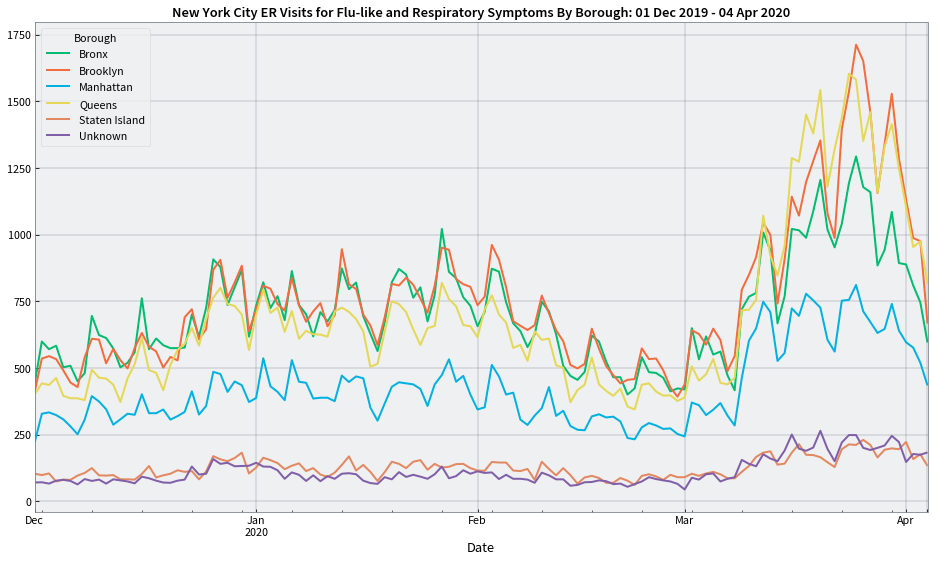

In [144]:
boroughs[boroughs['Date'] >= '2019-12-01'].groupby(['Date', 'Borough'])['Value'].sum().unstack('Borough').plot(kind='line',
                                                                                                               title="New York City ER Visits for Flu-like and Respiratory Symptoms By Borough: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2019-12-01']['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                    boroughs[boroughs['Date'] >= '2019-12-01'].groupby('Date')['Value'].sum().index.max().date().strftime("%d %b %Y")))

In [145]:
boroughs[boroughs['Borough'] == borough].groupby('Date')['Value'].sum().resample('D').sum().index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
               '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
               '2020-04-03', '2020-04-04'],
              dtype='datetime64[ns]', name='Date', length=1556, freq='D')

In [146]:
boroughs[boroughs['Borough'] == borough].groupby('Date')['Value'].sum().resample('D').sum()

Date
2016-01-01     489
2016-01-02     566
2016-01-03     527
2016-01-04     501
2016-01-05     396
              ... 
2020-03-31    1248
2020-04-01    1105
2020-04-02     953
2020-04-03     975
2020-04-04     815
Freq: D, Name: Value, Length: 1556, dtype: int64

In [147]:
models = []



for borough in tqdm(boroughs[-boroughs['Borough'].isin(['Staten Island', 'Unknown'])]['Borough'].unique()):
    model = sm.tsa.statespace.SARIMAX(boroughs[boroughs['Borough'] == borough].groupby('Date')['Value'].sum().resample('D').sum(),
                                      order=(1, 1, 1),
                                      seasonal_order=(1, 1, 1, 52),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    models.append({borough: model.fit()})

100%|██████████| 4/4 [30:27<00:00, 456.97s/it]


In [148]:
borough_results = {}

for model in models:
    for k, v in model.items():
        borough_results[k] = v

In [149]:
colors = {'Manhattan': '#00bc70',
          'Brooklyn': '#00b1e1', 
          'Queens': '#5b6670',
          'Bronx': '#f36c3f'}

Text(0.5, 1.0, '45 Day Forecast of New York City ER Visits for Flu-like and Respiratory Symptoms By Borough: 01 Dec 2019 - 10 May 2020')

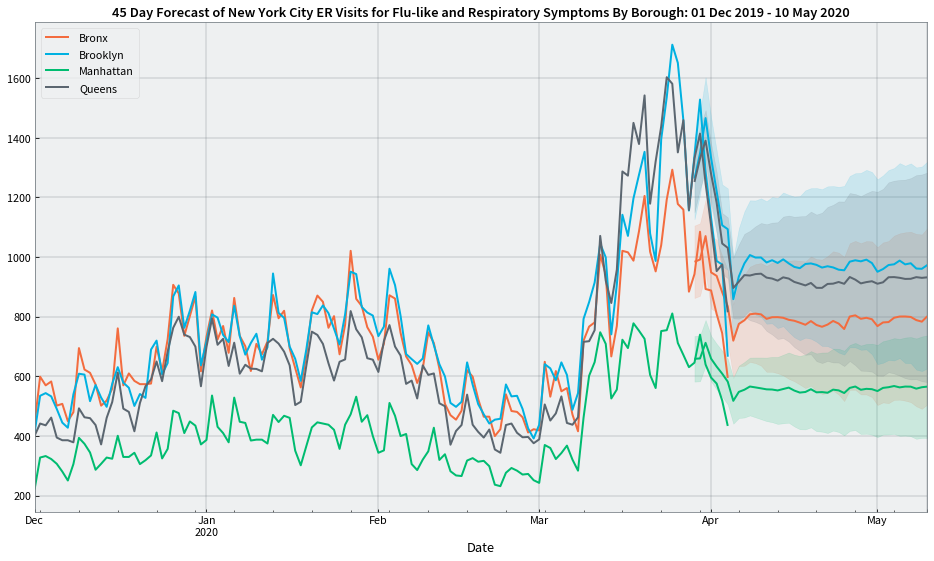

In [150]:
figsize(16, 9)

ax = plt.subplot(111)

for borough in boroughs[-boroughs['Borough'].isin(['Staten Island', 'Unknown'])]['Borough'].unique():
    borough_forecast = borough_results[borough].get_prediction(start='2020-03-29', end='2020-05-10', anchor='2020-03-29', alpha=0.05, full_results=True)
    boroughs[(boroughs['Borough'] == borough) & (boroughs['Date'] >= '2019-12-01')].groupby('Date')['Value'].sum().plot(kind='line',
                                                                                 label=borough,
                                                                                 legend=True,
                                                                                 color=colors[borough],
                                                                                 ax=ax)

    
    borough_forecast.predicted_mean.plot(kind='line', label="_nolegend_", color=colors[borough], ax=ax, legend=False)
    conf = borough_forecast.conf_int(alpha=0.05)

    borough_lower_series = pd.Series(conf.iloc[:, 0], borough_forecast.predicted_mean.index)
    borough_upper_series = pd.Series(conf.iloc[:, 1], borough_forecast.predicted_mean.index)
    
    ax.fill_between(borough_forecast.predicted_mean.index, borough_lower_series, borough_upper_series, alpha=0.15, color=colors[borough])

ax.legend(loc='upper left')
ax.set_title("45 Day Forecast of New York City ER Visits for Flu-like and Respiratory Symptoms By Borough: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2019-12-01']['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                    borough_forecast.predicted_mean.index.max().date().strftime("%d %b %Y")))

In [151]:
from matplotlib.cm import Reds
from matplotlib.colors import to_hex

geo_json = requests.get('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/new-york-city-boroughs.geojson').json()

def calculate_color(count, minimum, value_range):
    normalized_count = (count - minimum) / value_range

    mpl_color = Reds(normalized_count)

    gmaps_color = to_hex(mpl_color, keep_alpha=False)

    return gmaps_color

def calculate_colors(series_dict, geo_json, feature_property):
    minimum, maximum, value_range = create_range(series_dict)
    
    colors = []
    for feature in geo_json['features']:
        property_name = feature['properties'][feature_property]
        try:
            count = series_dict[property_name]
            color = calculate_color(count, minimum, value_range)
        except KeyError:
            # no arrest count for that precinct: return default color
            color = (255, 255, 255, 0.3)
        colors.append(color)
        
    return colors
        
def create_range(series):
    minimum = min(series.values())
    maximum = max(series.values())
    value_range = (maximum - minimum)
    
    return minimum, maximum, value_range
    
def create_choropleth(series, geo_json, feature_property):
    series_dict = series.to_dict()
    
    colors = calculate_colors(series_dict, geo_json, feature_property)

    choropleth = gmaps.geojson_layer(
        geo_json,
        fill_color=colors,
        stroke_color=colors,
        fill_opacity=0.8)
    
    m = gmaps.Map()    
    m.add_layer(choropleth)
    return m

NameError: name 'requests' is not defined

In [ ]:
boroughs['Borough'] = boroughs['Dim1Value']

In [ ]:
boroughs[boroughs['Date'] >= '2019-12-01'].groupby(['Date', 'Borough'])['Value'].sum().unstack('Borough').sum().sort_values().plot(kind='barh',
                                                                                                                                   title="Total NYC ER Visits for Flu-like and Respiratory Symptoms By Borough Since 1 Dec 2019")

In [ ]:
m = create_choropleth(boroughs[boroughs['Date'] >= '2019-12-01'].groupby(['Date', 'Dim1Value'])['Value'].sum().unstack('Dim1Value').sum(),
                      geo_json,
                      'name')
m

In [ ]:
def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices


def highlight_datetimes(indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(df.index[indices[i]], df.index[indices[i] + 1], facecolor='green', edgecolor='none', alpha=.5)
        i += 1
        
weekend_indices = find_weekend_indices(df[df['Date'] >= '2019-12-01'].groupby('Date')['Value'].sum().resample('D').sum().index)